#Face Recognition
In this hands-on project, the goal is to build a face identification model to recognize
faces.
##Dataset
Aligned Face Dataset from Pinterest
This dataset contains 10,770 images for 100 people. All images are taken from
'Pinterest' and aligned using dlib library.
##Overview
In this problem, we use a pre-trained model trained on Face recognition to recognize
similar faces.
Here, we are particularly interested in recognizing whether two given faces are of the
same person or not. Below are the steps involved in the project.
- Load the dataset and create the metadata.
- Check some samples of metadata.
- Load the pre-trained model and weights.
- Generate Embedding vectors for each face in the dataset.
- Build distance metrics for identifying the distance between two given images.
- Use PCA for dimensionality reduction.
- Build an SVM classifier to map each image to its right person.
- Predict using the SVM model.

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [1]:
import tensorflow
from zipfile import ZipFile
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

random_state = 2020

tensorflow.__version__

'2.3.0'

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Change current working directory to project folder (1 mark)

In [3]:
#### Add your code here ####
%cd '/content/drive/My Drive/Colab Notebooks/Advance_computer_vision_face_recog'

/content/drive/My Drive/Colab Notebooks/Advance_computer_vision_face_recog


### Extract the zip file (2 marks)
- Extract Aligned Face Dataset from Pinterest.zip

In [4]:
#### Add your code here ####
with ZipFile('Aligned Face Dataset.zip', 'r') as zip:
  zip.extractall()

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [5]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

### Define function to load image
- Define a function to load image from the metadata

In [6]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image (2 marks)
- Load one image using the function "load_image"

In [7]:
#### Add your code here ####
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)
labels = np.array([meta.name for meta in metadata])

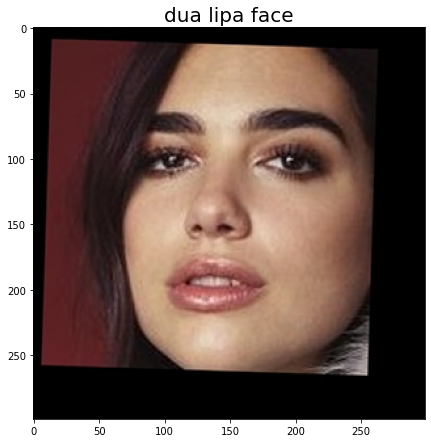

In [8]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model (2 marks)
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [10]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

### Get vgg_face_descriptor

In [11]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [12]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images (5 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [13]:
# embeddings = np.zeros((metadata.shape[0], 2622))

# for i, m in enumerate(metadata):
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [14]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

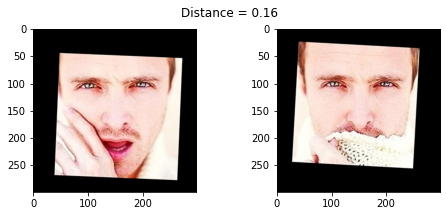

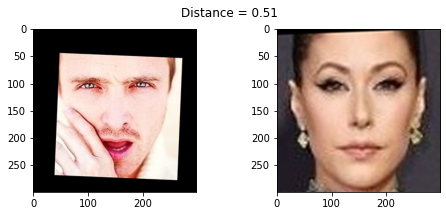

In [15]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

### Create train and test sets (5 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [16]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities

#### Add your code here ####
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
#### Add your code here ####
y_test = targets[test_idx]

### Encode the Labels (3 marks)
- Encode the targets
- Use LabelEncoder

In [17]:
from sklearn.preprocessing import LabelEncoder

#### Add your code here ####
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

### Standardize the feature values (3 marks)
- Scale the features using StandardScaler

In [18]:
# Standarize features
from sklearn.preprocessing import StandardScaler

#### Add your code here ####
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Reduce dimensions using PCA (3 marks)
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [19]:
from sklearn.decomposition import PCA

#### Add your code here ####
pca = PCA(n_components = 128)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 128)

(1197, 128)

### Build a Classifier (3 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [20]:
from sklearn.svm import SVC

#### Add your code here ####
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.999


In [21]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.949


In [22]:
p = cv2.resize(load_image(metadata[test_idx][10].image_path()), (224, 224)).shape

In [23]:
sample_img = load_image(metadata[test_idx][10].image_path())
sample_img = (sample_img/255.).astype(np.float32)
# Resize
sample_img = cv2.resize(sample_img, (224, 224))

# Obtain embedding vector for sample image
embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
# Scaled the vector and reshape
embedding_scaled = sc.transform(embedding.reshape(1, -1))
# Predict
sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
pred_name = encoder.inverse_transform(sample_pred)[0]

In [24]:
sample_pred

array([1])

In [25]:
encoder.inverse_transform(sample_pred)[0]

'pins_Alvaro Morte'

### Test results (1 mark)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

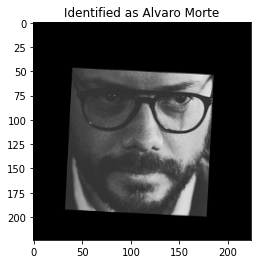

In [26]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())

# example_prediction = #### Add your code here ####

example_image = (example_image/255.).astype(np.float32)
# Resize
example_image = cv2.resize(example_image, (224, 224))

# Obtain embedding vector for sample image
embedding = vgg_face_descriptor.predict(np.expand_dims(example_image, axis = 0))[0]
# Scaled the vector and reshape
embedding_scaled = sc.transform(embedding.reshape(1, -1))
# Predict
example_prediction = svc_pca.predict(pca.transform(embedding_scaled))

example_identity = encoder.inverse_transform(example_prediction)[0].split('_')[-1].title().strip()

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');